In [59]:
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns

import os

# A. Data Exploration

In [139]:
path_csv = os.path.join(os.environ['HOME'], 'data', 'netflix', 'netflix_titles.csv')
dfNetflix = pd.read_csv(path_csv, parse_dates=['date_added'])
dfNetflix.loc[:,'lastnyear'] = 2021-dfNetflix['release_year']
dfNetflix = dfNetflix[dfNetflix.lastnyear <= 15]

In [140]:
len(dfNetflix)

7042

In [141]:
dfNetflix.dtypes

show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
lastnyear                int64
dtype: object

In [142]:
dfNetflix[:3]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,lastnyear
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,1
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,5
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",10


## Types of media

<AxesSubplot:xlabel='type', ylabel='count'>

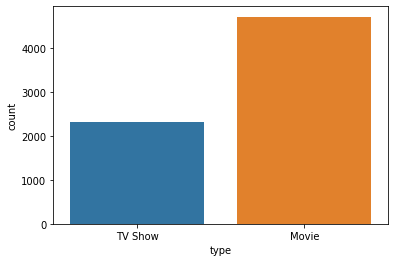

In [143]:
sns.countplot(x=dfNetflix['type'])

## Country of origins

In [144]:
dfCnt = dfNetflix.groupby('country')['show_id'].count()\
    .reset_index(name='count')\
    .sort_values('count',ascending=False)

sumall = dfCnt["count"].sum()
dfCnt.loc[:, "%"] = dfCnt["count"] * 100 / sumall
dfCnt[:10]

,country,count,%
519,United States,2255,34.406469
215,India,774,11.809582
437,United Kingdom,372,5.675923
274,Japan,207,3.158377
372,South Korea,182,2.776930
49,Canada,174,2.654867
380,Spain,134,2.044553
142,France,112,1.708880
423,Turkey,94,1.434239
289,Mexico,93,1.418981


## Recency of movies/shows being added each Quarter

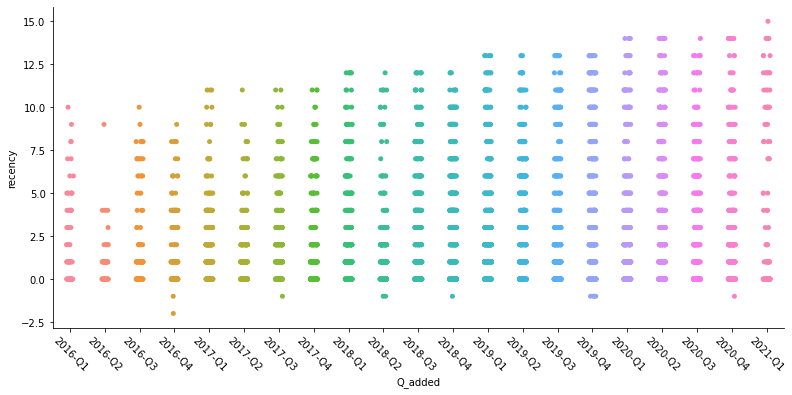

In [187]:
def getQ(dt):
    q = 1+(dt.month-1)//3
    return f'{dt.year}-Q{q}'

def recency(rel_year, dt):
    return dt.year - rel_year

dfAdded = dfNetflix[['release_year','date_added']]
dfAdded = dfAdded[dfAdded['date_added'].notna()]
dfAdded.loc[:,'Q_added'] = dfAdded['date_added'].apply(getQ)
dfAdded.loc[:,'recency'] = dfAdded['date_added'].dt.year - dfAdded['release_year']
dfAdded = dfAdded.sort_values(['Q_added'])

g = sns.catplot(data=dfAdded[dfAdded['Q_added']>='2016-Q1'], x='Q_added', y='recency')
g.set_xticklabels(rotation=315)
g.fig.set_figwidth(12.5)

## Description v Genre

In [203]:
dfDG = dfNetflix[['description','listed_in','title']]
dfDG = dfDG[dfDG.title.str.len()>8]
dfDG.loc[:,'genre'] = dfDG['listed_in'].str.split(', ')
dfDG.drop('listed_in',inplace=True,axis=1)
dfDG

,description,title,genre
20,After accidentally connecting over the Interne...,​​Kuch Bheege Alfaaz,"[Dramas, Independent Movies, International Mov..."
21,"A taxi driver, a gangster and an athlete strug...",​Goli Soda 2,"[Action & Adventure, Dramas, International Mov..."
22,A successful writer returns to the town that l...,​Maj Rati ​​Keteki,"[Dramas, International Movies]"
23,When a middle-aged divorcee returns to Kolkata...,​Mayurakshi,"[Dramas, International Movies]"
24,Seiya and the Knights of the Zodiac rise again...,​SAINT SEIYA: Knights of the Zodiac,"[Anime Series, International TV Shows]"
...,...,...,...
7778,Looking to survive in a world taken over by zo...,Zombieland,"[Comedies, Horror Movies]"
7779,An assortment of talent takes the stage for a ...,Zona Rosa,"[International TV Shows, Spanish-Language TV S..."
7784,"In this documentary, South African rapper Nast...",Zulu Man in Japan,"[Documentaries, International Movies, Music & ..."
7785,Dessert wizard Adriano Zumbo looks for the nex...,Zumbo's Just Desserts,"[International TV Shows, Reality TV]"


## Genres

In [209]:
dfGenres = dfDG['genre'].explode()
dfGenres.value_counts()

International Movies            1668
Dramas                          1355
Comedies                        1062
International TV Shows           965
Documentaries                    677
TV Dramas                        525
Independent Movies               454
TV Comedies                      435
Children & Family Movies         427
Action & Adventure               409
Romantic Movies                  378
Kids' TV                         345
Thrillers                        328
Docuseries                       323
Crime TV Shows                   320
Stand-Up Comedy                  310
Romantic TV Shows                284
Music & Musicals                 239
Horror Movies                    206
Reality TV                       205
British TV Shows                 191
Sports Movies                    145
Sci-Fi & Fantasy                 138
Korean TV Shows                  123
Anime Series                     121
Spanish-Language TV Shows        116
TV Action & Adventure            113
S

# B. Basic Text Classification Model

Let's try to classify `genre` of the movie/show based on just `title`

In [212]:
len(dfDG)

5839

## Explore vocaborary size

All text from title and description are taken into account

In [225]:
alltext = dfDG['description'] + dfDG['title']
alltext = alltext.str.split(' ').explode(ignore_index=True)
alltext = alltext.str.lower()
len(alltext) # number of distinct words in vocab

153056

Top 50 most frequent words

In [223]:
topwords = alltext.value_counts()[:50]
topwords

a              7489
the            6264
and            4508
to             4345
of             4090
in             3082
his            2126
with           1588
her            1385
an             1278
for            1247
on             1244
their          1118
this            974
when            926
from            876
as              796
is              733
by              623
after           619
who             551
he              545
that            545
at              538
new             494
but             479
into            452
–               450
life            437
young           430
up              416
they            354
man             340
family          323
two             321
love            318
world           316
she             305
out             293
woman           275
about           271
are             267
friends         266
while           240
documentary     240
series          239
must            234
find            229
one             228
be              210


## Text cleaning
Clean text for featurisation
- Removing articles
- Neutralise all capital cases

In [237]:
text = dfDG['title'] + dfDG['description']
text = text.str.lower().str.split(' ')
text = text.apply(lambda x: [s for s in x if s not in ['a','the']])
text

20      [​​kuch, bheege, alfaazafter, accidentally, co...
21      [​goli, soda, 2a, taxi, driver,, gangster, and...
22      [​maj, rati, ​​ketekia, successful, writer, re...
23      [​mayurakshiwhen, middle-aged, divorcee, retur...
24      [​saint, seiya:, knights, of, zodiacseiya, and...
                              ...                        
7778    [zombielandlooking, to, survive, in, world, ta...
7779    [zona, rosaan, assortment, of, talent, takes, ...
7784    [zulu, man, in, japanin, this, documentary,, s...
7785    [zumbo's, just, dessertsdessert, wizard, adria...
7786    [zz, top:, that, little, ol', band, from, texa...
Length: 5839, dtype: object

<bound method Series.apply of 20      [​​kuch, bheege, alfaazafter, accidentally, co...
21      [​goli, soda, 2a, taxi, driver,, a, gangster, ...
22      [​maj, rati, ​​ketekia, successful, writer, re...
23      [​mayurakshiwhen, a, middle-aged, divorcee, re...
24      [​saint, seiya:, knights, of, the, zodiacseiya...
                              ...                        
7778    [zombielandlooking, to, survive, in, a, world,...
7779    [zona, rosaan, assortment, of, talent, takes, ...
7784    [zulu, man, in, japanin, this, documentary,, s...
7785    [zumbo's, just, dessertsdessert, wizard, adria...
7786    [zz, top:, that, little, ol', band, from, texa...
Length: 5839, dtype: object>